<a href="https://colab.research.google.com/github/2xazo/SDAIA-Weak5-NLP/blob/main/W5_NLP_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip -q install transformers accelerate torch nltk scikit-learn


In [19]:
import json, re, math
import pandas as pd
import numpy as np

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
json_path = "/content/course_data.json"

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

type(data), len(data)


(dict, 8479)

In [21]:
rows = []

for course_code, course_obj in data.items():
    title = course_obj.get("course_title", "")
    reviews = course_obj.get("reviews", []) or []
    for r in reviews:
        rows.append({
            "course_code": course_code,
            "course_title": title,
            "review_text": (r.get("review_text") or "").strip(),
            "course_rating": (r.get("course_rating") or "").strip()
        })

df = pd.DataFrame(rows)

# keep only rows with actual text
df = df[df["review_text"].str.len() > 0].reset_index(drop=True)

df.head(), df.shape


(  course_code                        course_title  \
 0      CS 115  Introduction to Computer Science 1   
 1      CS 115  Introduction to Computer Science 1   
 2      CS 115  Introduction to Computer Science 1   
 3      CS 115  Introduction to Computer Science 1   
 4      CS 115  Introduction to Computer Science 1   
 
                                          review_text    course_rating  
 0                    go to office hours and practice     liked course  
 1  One of my least favourite courses. Although th...  disliked course  
 2  It starts with a very low pace but after midte...  disliked course  
 3  Took this in 2018 with no programming experien...     liked course  
 4  I loved everything about cs 115. Great instruc...     liked course  ,
 (14832, 4))

In [22]:
# Map review labels based on course_rating in the JSON (liked/disliked)
mapping = {
    "liked course": "Good",
    "disliked course": "Bad"
}

df["label"] = df["course_rating"].map(mapping)

# Drop anything unlabeled (if exists)
df = df.dropna(subset=["label"]).reset_index(drop=True)

df["label"].value_counts(), df.sample(5)


(label
 Good    9785
 Bad     4826
 Name: count, dtype: int64,
       course_code                 course_title  \
 3250     MATH 127  Calculus 1 for the Sciences   
 13149   MUSIC 216               Music Ensemble   
 2137     MATH 117   Calculus 1 for Engineering   
 7241    PSYCH 261     Physiological Psychology   
 3285      ECE 106    Electricity and Magnetism   
 
                                              review_text course_rating label  
 3250   Over half the course focused on grade 11 and 1...  liked course  Good  
 13149  Rest and relaxation babyyyyy!!! Free half cred...  liked course  Good  
 2137   Drill integration, it'll help a lot on the fin...  liked course  Good  
 7241   I took this online ... which I would advise no...  liked course  Good  
 3285   Not that hard if you've been passionate about ...  liked course  Good  )

In [23]:
df.value_counts('label')

,count
label,
Good,9785
Bad,4826


In [24]:
df["length_chars"] = df["review_text"].str.len()
df["length_words"] = df["review_text"].str.split().apply(len)

print("Total reviews:", len(df))
print("\nLabel counts:\n", df["label"].value_counts())
print("\nLength (words) stats:\n", df["length_words"].describe())

# quick peek at extremes
print("\nShortest review:\n", df.loc[df["length_words"].idxmin(), ["review_text","label"]].to_dict())
print("\nLongest review:\n", df.loc[df["length_words"].idxmax(), ["review_text","label"]].to_dict())


Total reviews: 14611

Label counts:
 label
Good    9785
Bad     4826
Name: count, dtype: int64

Length (words) stats:
 count    14611.00000
mean        39.70796
std         42.18147
min          1.00000
25%         13.00000
50%         28.00000
75%         51.00000
max        760.00000
Name: length_words, dtype: float64

Shortest review:
 {'review_text': 'Easiest', 'label': 'Good'}

Longest review:
 {'review_text': "I saw a review for another material science course (ME 115) that really embodied this course as well. So, I will use some of it here and just add a few points here there, so you know what makes this course really STAND OUT. THIS IS THEEEEE WORST COURSE I have ever taken and the most hated class in 2A for my cohort. The lectures were sooo……….boring and useless, which motivated most of the class to never show up. The textbook is completely useless as well, just pages and pages of conceptual ideas, and then just a bunch of numerical calculations you have no idea how to do. Oft

In [30]:
STOPWORDS = set(stopwords.words("english"))

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [w for w in text.split() if w not in STOPWORDS]
    return " ".join(tokens)

df["clean_text"] = df["review_text"].apply(clean_text)

df[["review_text","clean_text","label"]].head(10)


,review_text,clean_text,label
0,go to office hours and practice,go office hours practice,Good
1,One of my least favourite courses. Although th...,one least favourite courses although things ni...,Bad
2,It starts with a very low pace but after midte...,starts low pace midterm gets really fast canno...,Bad
3,Took this in 2018 with no programming experien...,took programming experience ever started prett...,Good
4,I loved everything about cs 115. Great instruc...,loved everything cs great instructors fair ass...,Good
5,I recommend finding a course with a language t...,recommend finding course language actually use...,Good
6,"I really enjoyed this course online, being co-...",really enjoyed course online co taught profess...,Good
7,math student who took this course since I had ...,math student took course since prior programmi...,Bad
8,The only way to do bad in this course is by no...,way bad course managing ur time properly mista...,Good
9,"Can be difficult at times, but a very rewardin...",difficult times rewarding fun course definitel...,Good


In [26]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert = AutoModel.from_pretrained(MODEL_NAME)

device = "cuda" if torch.cuda.is_available() else "cpu"
bert = bert.to(device)
bert.eval()

def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    summed = torch.sum(last_hidden_state * mask, dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)
    return summed / counts

@torch.no_grad()
def encode_texts(texts, batch_size=32):
    all_vecs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=256, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        out = bert(**enc)
        vec = mean_pool(out.last_hidden_state, enc["attention_mask"])
        all_vecs.append(vec.cpu().numpy())
    return np.vstack(all_vecs)

X = encode_texts(df["clean_text"].tolist(), batch_size=32)
y = df["label"].map({"Bad": 0, "Good": 1}).values

X.shape, y.shape


((14611, 768), (14611,))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

np.bincount(y_train), np.bincount(y_test)


(array([3861, 7827]), array([ 965, 1958]))

In [28]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "Linear SVM": LinearSVC(class_weight="balanced"),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=7))
    ])
}

for name, clf in models.items():
    clf.fit(X_train, y_train)

print("Done training.")


Done training.


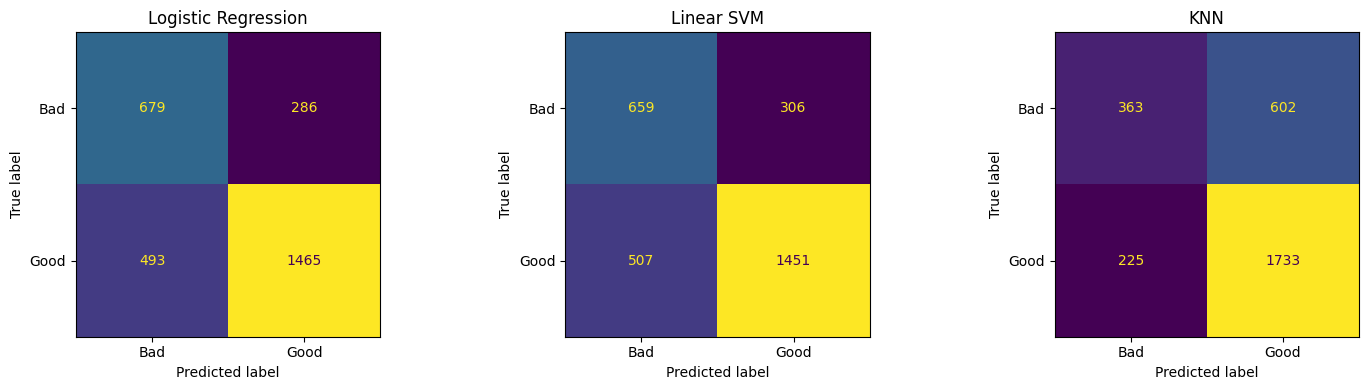

,Model,Accuracy,Precision,Recall,F1
0,KNN,0.717072,0.742184,0.885087,0.807361
1,Logistic Regression,0.733493,0.836665,0.748212,0.789970
2,Linear SVM,0.721861,0.825839,0.741062,0.781157


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_recall_fscore_support

def eval_and_plot_all(models, X_test, y_test, label_names=("Bad","Good")):
    n = len(models)
    cols = min(3, n)
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    axes = np.array(axes).reshape(-1)

    results = []

    for i, (name, clf) in enumerate(models.items()):
        y_pred = clf.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
        disp.plot(ax=axes[i], values_format="d", colorbar=False)
        axes[i].set_title(name)

        acc = accuracy_score(y_test, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average="binary", zero_division=0
        )

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": p,
            "Recall": r,
            "F1": f1
        })

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    results_df = pd.DataFrame(results).sort_values("F1", ascending=False).reset_index(drop=True)
    return results_df

results_df = eval_and_plot_all(models, X_test, y_test, label_names=("Bad","Good"))
results_df
